In [1]:
import requests_cache
requests_cache.install_cache('cache', allowable_codes=[200, 404], allowable_methods=['GET', 'POST'])
import requests
import pandas as pd
from tqdm.auto import tqdm
import json
pd.set_option("display.max_columns", None)

price_history = pd.read_csv("price_history.csv")
price_history.sort_values(price_history.columns.tolist(), inplace=True)

all_products = []
new_prices = []
for page in tqdm(range(1, 84)):
    try:
        r = requests.get("https://www.woolworths.co.nz/api/v1/products", params={
            "target": "browse",
            "inStockProductsOnly": "false",
            "size": 120,
            "page": page
        }, headers={
            "x-requested-with": "??",
            "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/129.0.0.0 Safari/537.36 Edg/129.0.0.0"
        }, timeout=5)
        r.raise_for_status()
        timestamp = int(r.created_at.timestamp())
        products = r.json()["products"]["items"]
        assert len(products) > 0, "No products"
        for product in products:
            sku = int(product["sku"])
            prices = price_history[price_history.SKU == sku].price
            if len(prices) == 0:
                last_price = None
            else:
                last_price = prices.iloc[-1]
            if product["price"]["salePrice"] != last_price:
                print(f"SKU {sku} price changed from {last_price} to {product['price']['salePrice']}")
                new_prices.append({
                    "SKU": sku,
                    "timestamp": timestamp,
                    "price": product["price"]["salePrice"]
                })
        all_products.extend(products)
    except Exception as e:
        raise
df = pd.json_normalize(all_products)
df.to_csv("products.csv", index=False)
df

  0%|          | 0/83 [00:00<?, ?it/s]

SKU 144607 price changed from 4.5 to 4.2
SKU 282456 price changed from 5.99 to 5.0
SKU 98255 price changed from 5.0 to 5.3
SKU 247942 price changed from 8.99 to 8.5
SKU 581130 price changed from 7.0 to 6.0
SKU 352492 price changed from 10.0 to 8.5
SKU 405838 price changed from 12.99 to 13.99
SKU 726007 price changed from 2.99 to 2.5
SKU 269645 price changed from 4.29 to 3.6
SKU 726061 price changed from 2.99 to 2.5
SKU 662935 price changed from 5.5 to 3.4
SKU 270752 price changed from 2.89 to 2.8
SKU 94536 price changed from 3.85 to 3.99
SKU 33183 price changed from 3.85 to 3.99
SKU 661681 price changed from 15.0 to 9.9
SKU 691505 price changed from 8.49 to 6.7
SKU 682050 price changed from 2.99 to 2.5
SKU 662120 price changed from 15.0 to 9.9
SKU 270715 price changed from 2.89 to 2.8
SKU 659120 price changed from 15.0 to 9.9
SKU 644266 price changed from 2.99 to 2.5
SKU 358078 price changed from 2.4 to 2.3
SKU 102301 price changed from 11.9 to 10.5
SKU 327006 price changed from 3.3 to

,type,name,barcode,variety,brand,slug,sku,unit,selectedPurchasingUnit,stockLevel,eachUnitQuantity,averageWeightPerUnit,hasShopperNotes,productTag,departments,subsAllowed,supportsBothEachAndKgPricing,adId,brandSuggestionId,brandSuggestionName,priceUnitLabel,availabilityStatus,onlineSample,onlineSampleRealProductMapId,price.originalPrice,price.salePrice,price.savePrice,price.savePercentage,price.canShowSavings,price.hasBonusPoints,price.isClubPrice,price.isSpecial,price.isNew,price.canShowOriginalPrice,price.discount,price.total,price.isTargetedOffer,price.averagePricePerSingleUnit,price.isBoostOffer,price.purchasingUnitPrice,price.orderedPrice,price.isUsingOrderedPrice,price.currentPricingMatchesOrderedPricing,price.extendedListPrice,price.originalAveragePricePerSingleUnit,images.small,images.big,quantity.min,quantity.max,quantity.increment,quantity.value,quantity.quantityInOrder,quantity.purchasingQuantityString,size.cupListPrice,size.cupPrice,size.cupMeasure,size.packageType,size.volumeSize,productTag.tagType,productTag.multiBuy,productTag.bonusPoints,productTag.additionalTag.name,productTag.additionalTag.link,productTag.additionalTag.imagePath,productTag.additionalTag.linkTarget,productTag.additionalTag.altText,productTag.targetedOffer,productTag.boostOffer,productTag.multiBuy.quantity,productTag.multiBuy.value,productTag.multiBuy.link,productTag.multiBuy.multiCupValue,productTag.additionalTag
0,Product,fresh fruit bananas yellow,9354829000064,yellow,fresh fruit,fresh-fruit-bananas-yellow,133211,Kg,None,3,None,0.25,None,NaN,"[{'id': 1, 'name': 'Fruit & Veg'}]",False,True,None,None,None,None,Out of Stock,None,0,3.45,3.45,0.00,0.0,True,False,False,False,False,True,None,None,False,0.86,False,None,None,False,None,None,None,https://assets.woolworths.com.au/images/2010/1...,https://assets.woolworths.com.au/images/2010/1...,0.2,100.0,0.2,None,None,None,3.45,3.450000,1kg,loose,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Product,woolworths butter salted,9300633725082,salted,woolworths,woolworths-butter-salted,827847,Each,None,3,None,NaN,None,NaN,"[{'id': 4, 'name': 'Fridge & Deli'}]",False,False,None,None,None,None,In Stock,None,0,6.49,6.49,0.00,0.0,True,False,False,False,False,True,None,None,False,NaN,False,None,None,False,None,None,None,https://assets.woolworths.com.au/images/2010/8...,https://assets.woolworths.com.au/images/2010/8...,1.0,4.0,1.0,None,None,None,1.30,1.300000,100g,None,500g,Other,NaN,NaN,Countdown's Own,/shop/productgroup/80842,/Content/PromotionTags/F24_Own_brand.png,_self,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Product,woolworths milk standard,9414742036509,standard,woolworths,woolworths-milk-standard,282768,Each,None,3,None,NaN,None,NaN,"[{'id': 4, 'name': 'Fridge & Deli'}]",False,False,None,None,None,None,In Stock,None,0,6.12,6.12,0.00,0.0,True,False,False,False,False,True,None,None,False,NaN,False,None,None,False,None,None,None,https://assets.woolworths.com.au/images/2010/2...,https://assets.woolworths.com.au/images/2010/2...,1.0,100.0,1.0,None,None,None,2.04,2.040000,1L,bottle,3L,Other,NaN,NaN,Countdown's Own,/shop/productgroup/80842,/Content/PromotionTags/F24_Own_brand.png,_self,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Product,fresh vegetable broccoli head,9414742350858,head,fresh vegetable,fresh-vegetable-broccoli-head,281082,Each,None,3,None,NaN,None,NaN,"[{'id': 1, 'name': 'Fruit & Veg'}]",False,False,None,None,None,None,Out of Stock,None,0,2.00,2.00,0.00,0.0,True,False,False,False,False,True,None,None,False,NaN,False,None,None,False,None,None,None,https://assets.woolworths.com.au/images/2010/2...,https://assets.woolworths.com.au/images/2010/2...,1.0,100.0,1.0,None,None,None,2.79,2.000000,1ea,,,Other,NaN,NaN,Fresh Deals,Self,/Content/PromotionTags/F24_Fresh_deal.png,_self,Fresh Deals,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Product,fresh vegetable carrots,9414742351053,,fresh vegetable,fresh-vegetable-carrots,135344,Kg,None,3,None,0.15,None,NaN,"[{'id': 1, 'name': 'Fruit & Veg'}]",False,True,None,None,Non

In [2]:
price_history = pd.concat([price_history, pd.DataFrame(new_prices)], ignore_index=True).sort_values(price_history.columns.tolist())
price_history

,SKU,timestamp,price
0,25,1728880327,3.99
1,168,1728880353,2.60
2,326,1728880348,4.30
3,579,1728880353,1.00
4,579,1729443688,2.00
...,...,...,...
21662,983433,1730048559,9.49
21663,991433,1728880355,10.80
21664,991433,1729443688,9.90
21665,991433,1730048476,10.80


In [3]:
price_history.groupby("SKU").size().value_counts()

3    3812
1    3779
2    2169
4     318
5     182
6       6
7       2
dtype: int64

In [4]:
delta = price_history.groupby("SKU").price.diff()
delta.describe()

count    11517.000000
mean         0.013530
std          2.504576
min        -28.990000
25%         -1.000000
50%          0.040000
75%          1.100000
max         28.990000
Name: price, dtype: float64

<Axes: ylabel='Frequency'>

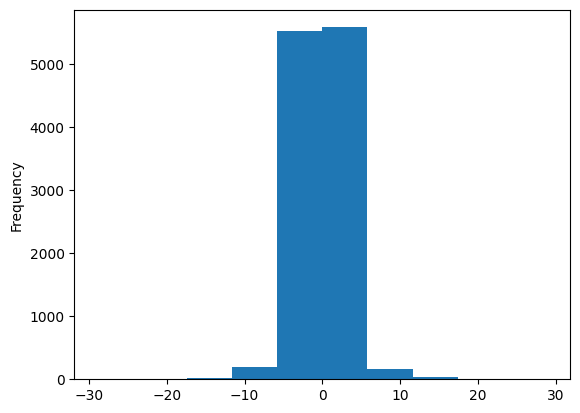

In [5]:
delta.plot.hist()

In [6]:
price_history.to_csv("price_history.csv", index=False)